In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed

from drift_diffusion.model import DriftDiffusionModel


def cov_to_corr(cov):
    "ii elements are standard errors, ij elements are correlations"
    stderr = np.sqrt(np.diag(cov))
    corr = cov / np.outer(stderr, stderr)
    np.fill_diagonal(corr, stderr)
    return corr


# load nguyen 2020 dataset
cols = ["subjectID", "coh", "rt", "response"]
corr_df = (
    pd.read_csv("datasets/allEpochsRAT200502.csv", usecols=cols)
    .query("subjectID == 482 and coh == 0.65")
    .assign(
        response=lambda x: x["response"].map({1: 1, 0: -1}),
        rt=lambda x: x["rt"] - x["rt"].min() + 1e-2,
    )
)
X, y = corr_df["rt"].to_numpy(), corr_df["response"].to_numpy()

# intitialize ddm
ddm = DriftDiffusionModel()
ddm.fit(X, y)

# params for simulation
param_names = ["a", "v", "z"]
matrix_names = [f"{i},{j}" for i in param_names for j in param_names]
params = ddm.params_
sim_params = {k: v for k, v in zip(param_names, params)}

In [3]:
n_samples, n_repeats = 1000, 500


@delayed
def run_simulation(repeat):
    ddm.set_params(random_state=repeat, cov_estimator="all", **sim_params)
    X_, y_ = ddm.sample_from_pdf(n_samples=1000, x_range=(1e-5, 4))
    ddm.fit(X_, y_)

    corr_df = [
        {"estimator": k, **{matrix_names[i]: val for i, val in enumerate(cov_to_corr(v).flatten())}}
        for k, v in ddm.covariance_.items()
    ]

    return ddm.params_, corr_df


with Parallel(n_jobs=-2) as parallel:
    results = parallel(run_simulation(repeat) for repeat in range(n_repeats))

# results to dataframes for plotting
params_ = pd.DataFrame([res[0] for res in results], columns=param_names)
correlations_ = pd.DataFrame([row for res in results for row in res[1]])

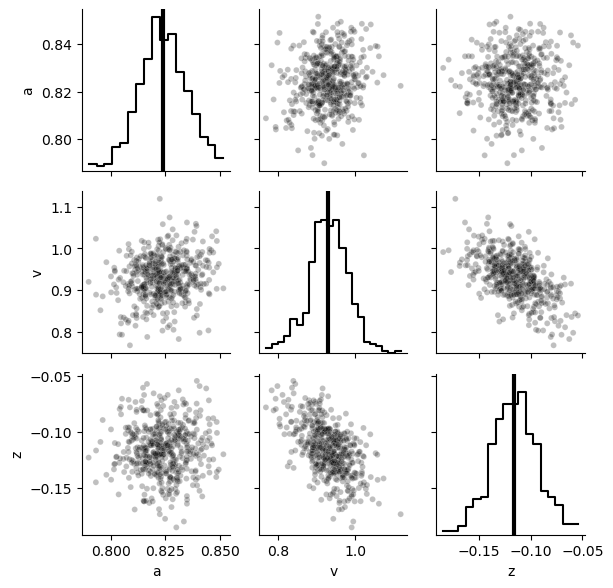

In [4]:
g = sns.PairGrid(params_, height=2)
g.map_offdiag(sns.scatterplot, color="k", alpha=0.25, size=1)
g.map_diag(sns.histplot, color="k", element="step", fill=False)
g.map_diag(lambda x, **kwargs: plt.axvline(sim_params[x.name], c="k", lw=3))

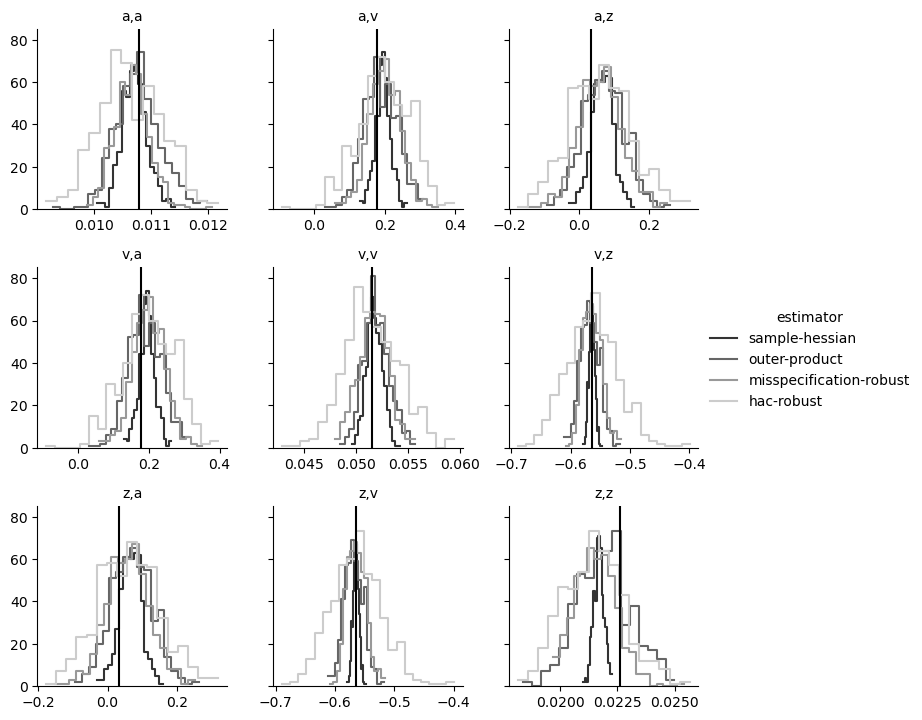

In [5]:
correlations = cov_to_corr(np.cov(params_.T)).flatten()

g = sns.FacetGrid(
    correlations_.melt(id_vars="estimator"),
    hue="estimator",
    col="variable",
    col_wrap=3,
    sharex=False,
    height=2.5,
    palette="binary_r",
)
g.map(sns.histplot, "value", element="step", fill=False)
g.set_titles("{col_name}")
g.set_xlabels("")
g.set_ylabels("")
g.add_legend()

for ax, correlation in zip(g.axes.flat, correlations):
    ax.axvline(x=correlation, c="k", lw=1.5)